
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [2]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm
import time
from transformers import BertTokenizer, BertModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, log_loss, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [3]:
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

In [4]:
df = pd.read_csv('../datasets/buscape_preprocessed.csv')

In [5]:
df.head(3)

,review_text,rating
0,estou muito satisfeito o visor e melhor do que...,1
1,muito boa o que gostei preco o que nao gostei ...,1
2,rapida otima qualidade de impressao e facil de...,1


In [6]:
print(f'{df.shape[0]} instancias, {df.shape[1]} classes')

133632 instancias, 2 classes


#### Dividindo dataset em 12 partes balanceadas, cada parte com 8.3% do dataset.
- Somente para treinamentos no modelo com menos dados;
- Nos treinamentos que iremos gerar estimativas, utilizaremos a base completa;

In [87]:
#batch_1, batch_2 = train_test_split(df, test_size=0.5, stratify=df['rating'], random_state=42)
#batch_3, batch_4 = train_test_split(batch_2, test_size=0.5, stratify=batch_2['rating'], random_state=42)
#batch_5, batch_6 = train_test_split(batch_4, test_size=0.5, stratify=batch_4['rating'], random_state=42)
#batch_7, batch_8 = train_test_split(batch_6, test_size=0.5, stratify=batch_6['rating'], random_state=42)
#batch_9, batch_10 = train_test_split(batch_8, test_size=0.5, stratify=batch_8['rating'], random_state=42)
#batch_11, batch_12 = train_test_split(batch_10, test_size=0.5, stratify=batch_10['rating'], random_state=42)

#### Quantidade de avaliações positivas e negativas split_df_01

In [7]:
df['rating'].value_counts()

rating
1    66816
0    66816
Name: count, dtype: int64

In [8]:
reviews = df['review_text']
labels = df['rating']

#### Tokenização e geração dos embeddings
- Este processo pode demorar alguns instantes para ser concluído

In [9]:
embeddings = []
for review in tqdm((reviews), desc="Processing"):
    inputs = tokenizer(
        str(review),
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=128,
    )
    with torch.no_grad():
        output = model(**inputs)
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())

Processing: 100%|██████████| 133632/133632 [5:38:08<00:00,  6.59it/s]  


In [11]:
embeddings_array = np.vstack(embeddings)

In [12]:
print(f'{embeddings_array.shape[0]} embeddings de {embeddings_array.shape[1]} dimensões')

133632 embeddings de 768 dimensões


#### Feature based 1

In [13]:
additional_features = np.array([[len(str(review).split())] for review in reviews])

In [14]:
print(embeddings_array.shape)
print(additional_features.shape)

(133632, 768)
(133632, 1)


#### Combinando embeddings_array e additional_features

In [15]:
combined_features = np.hstack((embeddings_array, additional_features))

#### Dividindo dataset treino e teste

In [16]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

In [17]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [18]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

#### Arquitetura rede neural MLP

In [19]:
DROPOUT = 0
LEARNING_RATE = 2.5e-5
EPOCHS = 5
K_FOLDS = 10
VERBOSE = 0
PATIENCE = 3
BATCH_SIZE = 32

In [20]:
model = Sequential([
    Dense(24, activation='relu', input_dim=X_train_tensor.shape[1]),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                18480     
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 18,505
Trainable params: 18,505
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

#### Cross-validation

In [22]:
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

#### Ajustando path para salvar os pesos

In [23]:
CHECKPOINT=ModelCheckpoint(
    filepath='../weights/tlm_peq_mult_weights.hdf5', 
    verbose=VERBOSE, 
    save_best_only=True
)
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=PATIENCE)
CALLBACKS = [CHECKPOINT, EARLY_STOP]

#### Treinamento do modelo

In [24]:
fold = 0

fold_train_losses = []
fold_train_accuracies = []
fold_train_f1_scores = []
fold_train_mses_scores = []

fold_val_accuracies = []
fold_val_f1_scores = []
fold_val_mses = []
fold_val_losses = []

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

val_tprs = []
val_aucs = []
val_mean_fpr = np.linspace(0, 1, 100)

print('Iniciando treinamento...')
for train_indices, val_indices in tqdm(kf.split(combined_features), desc="Processing"):
    fold+=1
    print(f'treinando fold ---> {fold}')
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
    
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        verbose=VERBOSE,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS,
    )
    
    # train loss each fold
    fold_train_losses.append(model_history.history['loss'])
    
    # train accuracy each fold
    fold_train_accuracies.append(model_history.history['accuracy'])
    
    # train f1 score em cada fold
    y_pred_train = model.predict(X_train_fold_tensor)
    y_pred_train_binary = np.round(y_pred_train)
    fold_train_f1_scores.append(f1_score(y_train_fold_tensor, y_pred_train_binary))
    
    # train mse each fold
    fold_train_mses_scores.append(mean_squared_error(y_train_fold_tensor, y_pred_train_binary))
    
    # train roc curve and auc
    fpr, tpr, thresholds = roc_curve(y_train_fold_tensor, y_pred_train_binary)
    roc_auc = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(roc_auc)
    
    # -----------------------------------------------------------------------------
    
    # validation predicts
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    # validation accuracy
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_val_accuracies.append(fold_accuracy)
    
    # validation f1 score
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_val_f1_scores.append(fold_f1_score)
    
    # validation mse each fold
    fold_val_mses.append(mean_squared_error(y_val_fold, y_pred_val_binary))
    
    # validation loss each fold
    fold_val_losses.append(log_loss(y_val_fold, y_pred_val_binary))
    
    # validation roc curve and auc
    val_fpr, val_tpr, thresholds = roc_curve(y_val_fold_tensor, y_pred_val_binary)
    val_roc_auc = auc(val_fpr, val_tpr)
    val_tprs.append(np.interp(val_mean_fpr, val_fpr, val_tpr))
    val_aucs.append(roc_auc)

print('Treinamento finalizado!')

Iniciando treinamento...


Processing: 0it [00:00, ?it/s]

treinando fold ---> 1
418/418 [==============================] - 0s 765us/step


Processing: 1it [00:27, 27.29s/it]

treinando fold ---> 2
418/418 [==============================] - 0s 729us/step


Processing: 2it [00:53, 26.74s/it]

treinando fold ---> 3
418/418 [==============================] - 0s 738us/step


Processing: 3it [01:20, 26.84s/it]

treinando fold ---> 4
418/418 [==============================] - 0s 733us/step


Processing: 4it [01:46, 26.37s/it]

treinando fold ---> 5
418/418 [==============================] - 0s 722us/step


Processing: 5it [02:12, 26.15s/it]

treinando fold ---> 6
418/418 [==============================] - 0s 736us/step


Processing: 6it [02:37, 25.89s/it]

treinando fold ---> 7
418/418 [==============================] - 0s 744us/step


Processing: 7it [03:03, 25.91s/it]

treinando fold ---> 8
418/418 [==============================] - 0s 732us/step


Processing: 8it [03:28, 25.75s/it]

treinando fold ---> 9
418/418 [==============================] - 0s 751us/step


Processing: 9it [03:54, 25.67s/it]

treinando fold ---> 10
418/418 [==============================] - 0s 732us/step


Processing: 10it [04:19, 25.98s/it]

Treinamento finalizado!


In [25]:
train_losses_mean_value = round(np.mean([np.mean(losses) for losses in fold_train_losses]),4)
train_accuracies_mean_value = round(np.mean([np.mean(accuracy) for accuracy in fold_train_accuracies]),4)
train_f1_score_mean_value = round(np.mean([np.mean(f1_sc) for f1_sc in fold_train_f1_scores]),4)
train_mses_mean_value = round(np.mean([np.mean(mses) for mses in fold_train_mses_scores]),4)

val_losses_mean_value = round(np.mean([np.mean(val_loss) for val_loss in fold_val_losses]),4)
val_accuracies_mean_value = round(np.mean([np.mean(val_acc) for val_acc in fold_val_accuracies]),4)
val_f1_scores_mean_value = round(np.mean([np.mean(val_f1_sc) for val_f1_sc in fold_val_f1_scores]),4)
val_mse_mean_value = round(np.mean([np.mean(val_mse) for val_mse in fold_val_mses]),4)

print(f'Mean train loss: {train_losses_mean_value}')
print(f'Mean train accuracy: {train_accuracies_mean_value}')
print(f'Mean train F1 Score: {train_f1_score_mean_value}')
print(f'Mean train MSE Score: {"{:.4f}".format(train_mses_mean_value)}')
print('-'*40)
print(f'Mean validation loss: {val_losses_mean_value}')
print(f'Mean validation accuracy: {val_accuracies_mean_value}')
print(f'Mean validation F1_score: {val_f1_scores_mean_value}')
print(f'Mean validation MSE: {val_mse_mean_value}')

Mean train loss: 0.3912
Mean train accuracy: 0.8251
Mean train F1 Score: 0.8325
Mean train MSE Score: 0.1698
----------------------------------------
Mean validation loss: 2.7214
Mean validation accuracy: 0.8293
Mean validation F1_score: 0.8316
Mean validation MSE: 0.1707


In [26]:
def plot_k_folds_metrics(history, metric):
    plt.figure(figsize=(10, 6))
    for fold_num, fold_loss in enumerate(history):
        plt.plot(fold_loss, label=f'Fold {fold_num+1}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Training {metric}')
    plt.title(f'Training {metric} per Epoch for Each Fold')
    plt.legend()
    plt.show()
    
def plot_train_scores(metrics_list, k_folds_list, metric_name):
    folds = list(range(1,k_folds_list+1))
    val_acc = metrics_list

    plt.figure(figsize=(6, 4))
    plt.plot(folds, val_acc, marker='o')
    plt.title(f'Train {metric_name} Over Folds')
    plt.xlabel('Folds')
    plt.ylabel(f'Train {metric_name}')
    plt.grid(True)
    plt.xticks(folds)
    plt.ylim(0.8, 1.0) 
    plt.show()

def plot_roc_auc_curve(desc, mean_tpr, mean_auc):
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'{desc} Mean ROC curve (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{desc} Mean Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

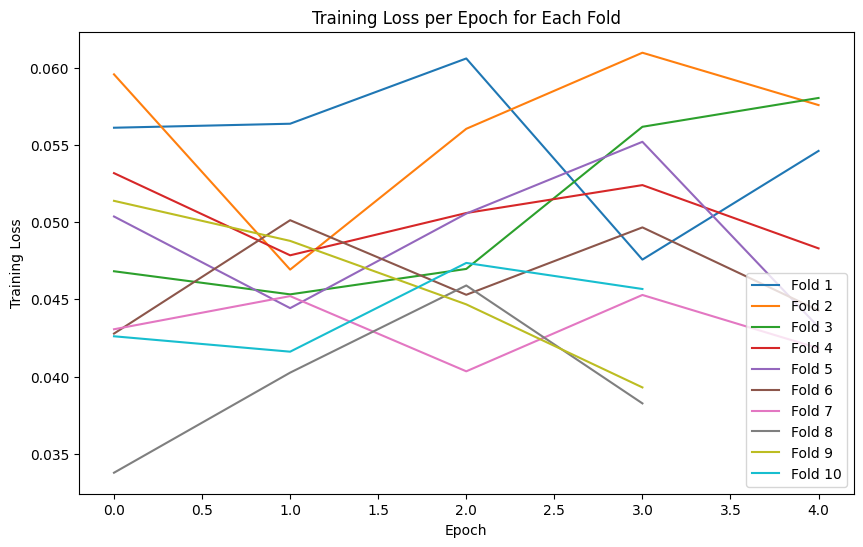

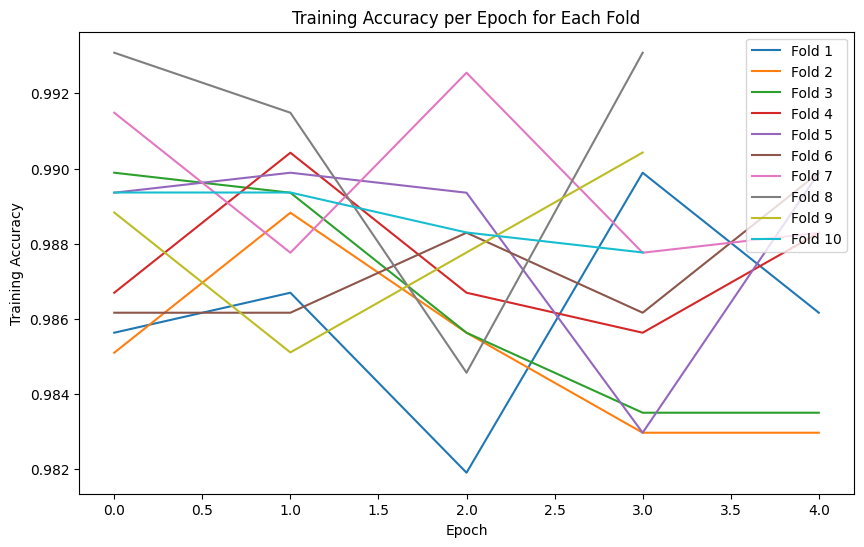

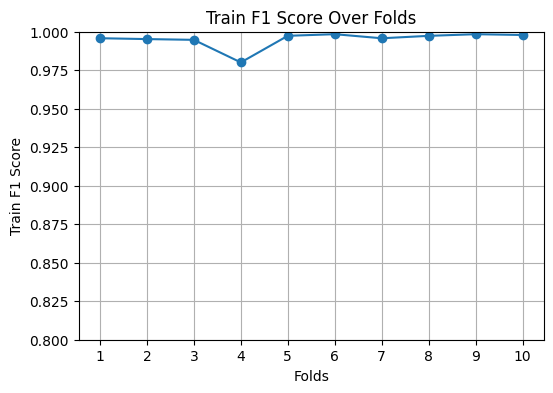

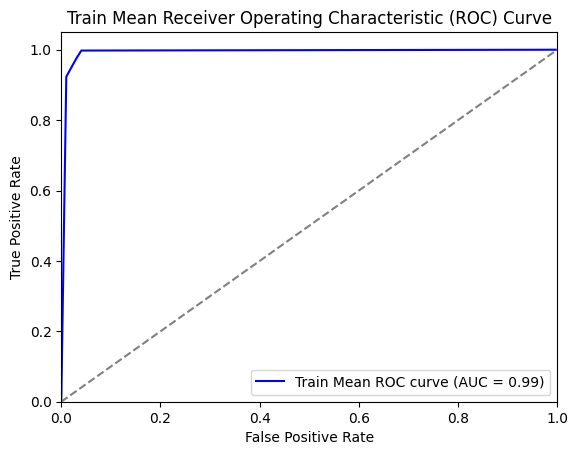

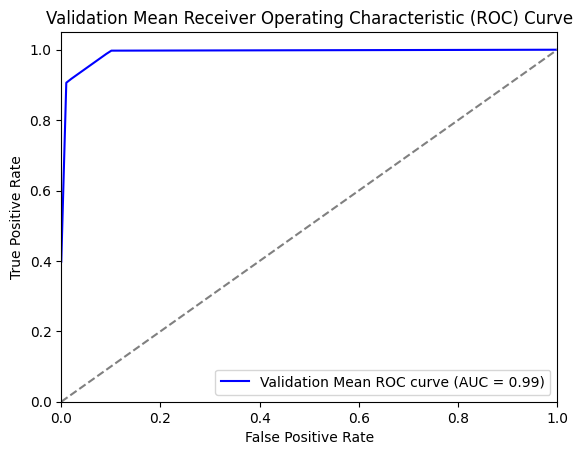

In [86]:
plot_k_folds_metrics(fold_train_losses, 'Loss')
plot_k_folds_metrics(fold_train_accuracies, 'Accuracy')
plot_train_scores(fold_train_f1_scores, K_FOLDS, 'F1 Score')

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plot_roc_auc_curve('Train', mean_tpr, mean_auc)

val_mean_tpr = np.mean(val_tprs, axis=0)
val_mean_auc = auc(val_mean_fpr, val_mean_tpr)
plot_roc_auc_curve('Validation', val_mean_tpr, val_mean_auc)